# FMR standard problem
## Problem specification
We choose a cuboidal thin film permalloy sample measuring $120 \times 120 \times 10 \,\text{nm}^{3}$. The choice of a cuboid is important as it ensures that the finite difference method employed by OOMMF does not introduce errors due to irregular boundaries that cannot be discretized well. We choose the thin film geometry to be thin enough so that the variation of magnetization dynamics along the out-of-film direction can be neglected. Material parameters based on permalloy are:

Exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,

Magnetisation saturation $M_\text{s} = 8 \times 10^{5} \,\text{A/m}$,

Gilbert damping $\alpha = 0.008$.

An external magnetic bias field with magnitude $80 \,\text{kA/m}$ is applied along the direction $e = (1, 0.715, 0)$. 

We choose the external magnetic field direction slightly off the sample diagonal in order to break the system’s symmetry and thus avoid degenerate eigenmodes. First, we initialize the system with a uniform out-of-plane magnetization $m_{0} = (0, 0, 1)$. We relax the system using the Steepest Descent method. We refer to this stage of simulation as the relaxation stage, and its final relaxed magnetization configuration is saved to serve as the initial configuration for the next dynamic stage. 

In the next step (dynamic stage), a simulation is started using the equilibrium magnetisation configuration from the relaxation stage as the initial configuration. Now, the direction of an external magnetic field is altered to $e = (1, 0.7, 0)$. This simulation stage runs for $T = 10 \,\text{ns}$ while the (average and spatially resolved) magnetization $M(t)$ is recorded every $\Delta t = 5 \,\text{ps}$. The Gilbert damping in this dynamic simulation stage is $\alpha = 0.008$.

Details of this standard problem specification can be found in Ref. 1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import scipy.signal
%matplotlib inline
import fidimag

Lx = Ly = 120 # nm
Lz = 10 # nm
dx = dy = dz = 5 # nm
nx = int(Lx/dx)
ny = int(Ly/dy)
nz = int(Lz/dz)


A = 1.3e-11 # J/m
Ms = 8e5 # A/m
alpha = 0.008
B_mag = 80e3 # A / m
B_axis = np.array([1.0, 0.715, 0.0])
B = B_mag * B_axis / np.linalg.norm(B_axis)
m_init = np.array([0, 0, 1])
t_init = 5e-9

We create and relax the system.

In [2]:
#NBVAL_IGNORE_OUTPUT
mesh = fidimag.common.CuboidMesh(nx=nx, ny=ny, nz=nz,
                                 dx=dx, dy=dy, dz=dz,
                                 unit_length=1e-9)

sim = fidimag.micro.Sim(mesh, name='relax', driver='steepest_descent')
sim.driver.alpha = 1.0
sim.set_Ms(Ms)
sim.set_m(m_init)
sim.add(fidimag.micro.UniformExchange(A))
sim.add(fidimag.micro.Demag())
sim.add(fidimag.micro.Zeeman(B))
sim.driver.minimise(stopping_dm=1e-7, max_steps=20000)
np.save('m_relax.npy', sim.spin)

#max_tau=0.01     max_dm=2.34e-05   counter=0
#max_tau=0.01     max_dm=0.00164    counter=1000
#max_tau=0.01     max_dm=4.22e-05   counter=2000
#max_tau=0.01     max_dm=1.14e-05   counter=3000
#max_tau=0.01     max_dm=4.48e-06   counter=4000
#max_tau=0.01     max_dm=2.24e-06   counter=5000
#max_tau=0.01     max_dm=1.2e-06    counter=6000
#max_tau=0.01     max_dm=6.67e-07   counter=7000
#max_tau=0.01     max_dm=3.79e-07   counter=8000
#max_tau=0.01     max_dm=2.17e-07   counter=9000
#max_tau=0.01     max_dm=1.25e-07   counter=10000
FINISHED AT: max_tau=0.01     max_dm=9.99e-08   counter=10402


We can now plot the $z$ slice of magnetisation.

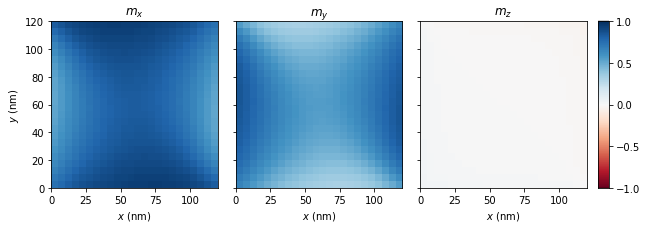

In [3]:
fidimag.common.plot(sim, component='all')

# Dynamic stage

In the dynamic stage, we change the field, 'shocking' the system, and allow the system to evolve in time. This can be thought about in the same way as plucking a guitar string and exciting different modes of the string.

In [4]:
Nsteps = 2001 # Number of steps in dynamic stage

# Change the external field
B_axis = np.array([1.0, 0.7, 0.0])
B = B_mag * B_axis / np.linalg.norm(B_axis)

mesh = fidimag.common.CuboidMesh(nx=nx, ny=ny, nz=nz,
                                 dx=dx, dy=dy, dz=dz,
                                 unit_length=1e-9)

sim = fidimag.micro.Sim(mesh, name='dynamic', driver='llg')
sim.driver.alpha = 1.0
sim.set_Ms(Ms)
sim.set_m(np.load('m_relax.npy'))
sim.add(fidimag.micro.UniformExchange(A))
sim.add(fidimag.micro.Demag())
sim.add(fidimag.micro.Zeeman(B))

sim.get_interaction('Zeeman').update_field(B)
sim.driver.alpha = alpha

ts = np.linspace(0, 10e-9, Nsteps)

In [5]:
#NBVAL_IGNORE_OUTPUT
for i, t in enumerate(ts):
    if i % 50 == 0:
        print('Step {}, t = {}'.format(i, t))
    sim.driver.run_until(t)
    sim.save_m()
    sim.save_vtk()

Step 0, t = 0.0
Step 50, t = 2.5e-10
Step 100, t = 5e-10
Step 150, t = 7.500000000000001e-10
Step 200, t = 1e-09
Step 250, t = 1.25e-09
Step 300, t = 1.5000000000000002e-09
Step 350, t = 1.7500000000000002e-09
Step 400, t = 2e-09
Step 450, t = 2.2500000000000003e-09
Step 500, t = 2.5e-09
Step 550, t = 2.7500000000000002e-09
Step 600, t = 3.0000000000000004e-09
Step 650, t = 3.25e-09
Step 700, t = 3.5000000000000003e-09
Step 750, t = 3.7500000000000005e-09
Step 800, t = 4e-09
Step 850, t = 4.250000000000001e-09
Step 900, t = 4.500000000000001e-09
Step 950, t = 4.75e-09
Step 1000, t = 5e-09
Step 1050, t = 5.250000000000001e-09
Step 1100, t = 5.5000000000000004e-09
Step 1150, t = 5.75e-09
Step 1200, t = 6.000000000000001e-09
Step 1250, t = 6.2500000000000005e-09
Step 1300, t = 6.5e-09
Step 1350, t = 6.750000000000001e-09
Step 1400, t = 7.000000000000001e-09
Step 1450, t = 7.25e-09
Step 1500, t = 7.500000000000001e-09
Step 1550, t = 7.750000000000002e-09
Step 1600, t = 8e-09
Step 1650, t =

# Postprocessing

We read in the data files and compute the spatially averaged power spectral density, which shows the distribution of power in the excited modes.

In [6]:
m_0 = np.load('m_relax.npy')
mxs = []
mys = []
mzs = []
for i in range(Nsteps):
    m = np.load('dynamic_npys/m_{}.npy'.format(i)) - m_0
    mxs.append(np.mean(m[0::3]))
    mys.append(np.mean(m[1::3]))
    mzs.append(np.mean(m[2::3]))

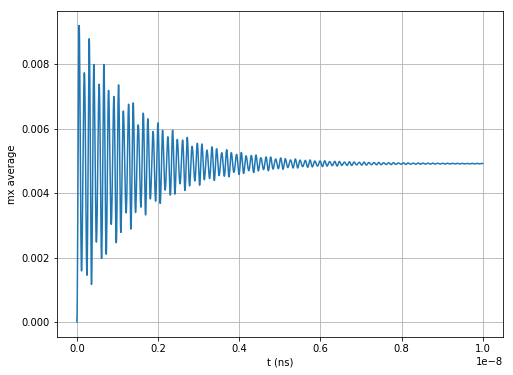

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(ts, mxs)
plt.xlabel('t (ns)')
plt.ylabel('mx average')
plt.grid()

(0, 50)

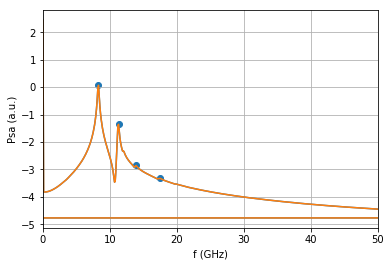

In [8]:
import scipy.fftpack
psd = np.log10(np.abs(scipy.fftpack.fft(mxs))**2 + \
               np.abs(scipy.fftpack.fft(mys))**2 + \
               np.abs(scipy.fftpack.fft(mzs))**2)
f_axis = scipy.fftpack.fftfreq(Nsteps, d=20e-9/4000)

plt.plot(f_axis/1e9, psd)
plt.xlim([0, 40])
plt.grid()
plt.xlabel('f (GHz)')
plt.ylabel('Psa (a.u.)')

peakind = scipy.signal.find_peaks(psd, width=2)[0]
plt.plot(f_axis/1e9, psd)
plt.scatter(f_axis[peakind]/1e9, psd[peakind])
plt.xlim([0, 50])

In [9]:
print("Lowest frequency peak = {} GHz".format(f_axis[peakind[0]]/1e9))

Lowest frequency peak = 8.295852073963019 GHz
